This notebook follows this tutorial by mlflow here : https://mlflow.org/docs/latest/traditional-ml/hyperparameter-tuning-with-child-runs/index.html

In [101]:
#import necessary libraries 
from datetime import datetime, timedelta
import math

import numpy as np
import optuna 
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

import mlflow

In [102]:
mlflow.set_tracking_uri("http://localhost:8080")


In [103]:
df = pd.read_csv("Clean_Dataset.csv")

In [104]:
df.dtypes

Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

In [105]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [106]:
df.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

list of changing object dtypes to ints \\
airline we can one hot encode\\
drop flight from training does not seem relevant \\
source city one hot encode\\
departure times label encode
stops label encode
arrival time label encode
destination city one hot encode
class label encode



In [107]:
label_cols = ['class', 'arrival_time', 'stops', 'departure_time']
one_hot_cols = ['destination_city', 'source_city', 'airline']

In [108]:

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

df[label_cols]


,class,arrival_time,stops,departure_time
0,1,5,2,2
1,1,4,2,1
2,1,1,2,1
3,1,0,2,4
4,1,4,2,4
...,...,...,...,...
300148,0,2,0,4
300149,0,5,0,0
300150,0,5,0,1
300151,0,2,0,1


In [109]:
ohe = OneHotEncoder()
one_hot_encoded = ohe.fit_transform(df[one_hot_cols])
# Convert the sparse matrix to a DataFrame
feature_names = ohe.get_feature_names_out(one_hot_cols)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=feature_names)
one_hot_encoded_df.head()
one_hot_encoded_df.columns

Index(['destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai',
       'source_city_Bangalore', 'source_city_Chennai', 'source_city_Delhi',
       'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai',
       'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara'],
      dtype='object')

In [136]:


df[['destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai',
       'source_city_Bangalore', 'source_city_Chennai', 'source_city_Delhi',
       'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai',
       'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']] = one_hot_encoded_df
X = df[[ 'departure_time',
       'stops', 'arrival_time', 'class', 'duration',
       'days_left', 'destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai',
       'source_city_Bangalore', 'source_city_Chennai', 'source_city_Delhi',
       'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai',
       'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


27131      7366
266857    64831
141228     6195
288329    60160
97334      6578
          ...  
5234       5026
5591       3001
168314     6734
175191     5082
287693    66465
Name: price, Length: 60031, dtype: int64

In [137]:
y_train

148417    13524
36879      9940
274531    55983
166397     7927
272722    55502
          ...  
119879    22869
259178    44280
131932     5102
146867     5574
121958     6339
Name: price, Length: 240122, dtype: int64

In [139]:
X_train.head()

,departure_time,stops,arrival_time,class,duration,days_left,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
148417,0,0,4,1,19.42,6,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36879,0,1,5,1,7.00,13,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
274531,0,0,0,0,21.17,44,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
166397,5,0,1,1,10.25,11,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
272722,5,0,5,0,26.50,5,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [140]:

for column in df.columns:
    value_counts = df[column].value_counts()
    print(f"Value counts for {column}:\n{value_counts}\n")

Value counts for Unnamed: 0:
Unnamed: 0
0         1
200091    1
200107    1
200106    1
200105    1
         ..
100050    1
100049    1
100048    1
100047    1
300152    1
Name: count, Length: 300153, dtype: int64

Value counts for airline:
airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

Value counts for flight:
flight
UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: count, Length: 1561, dtype: int64

Value counts for source_city:
source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

Value counts for departure_time:
departure_time
4    71146
1    66790
2    65102
5    48015
0    47794
3     1306
Name: count, dtype: int64

Value counts for stops:
stops
0

In [141]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,...,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,0,SpiceJet,SG-8709,Delhi,2,2,5,Mumbai,1,2.17,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,SpiceJet,SG-8157,Delhi,1,2,4,Mumbai,1,2.33,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,AirAsia,I5-764,Delhi,1,2,1,Mumbai,1,2.17,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,Vistara,UK-995,Delhi,4,2,0,Mumbai,1,2.25,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,Vistara,UK-963,Delhi,4,2,4,Mumbai,1,2.33,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [142]:
df.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price', 'destination_city_Bangalore',
       'destination_city_Chennai', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'source_city_Bangalore',
       'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai', 'airline_AirAsia',
       'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo',
       'airline_SpiceJet', 'airline_Vistara'],
      dtype='object')

In [143]:
graph_df = df[['departure_time', 'stops', 'arrival_time',
       'class', 'duration', 'days_left', 'price', 'destination_city_Bangalore',
       'destination_city_Chennai', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'source_city_Bangalore',
       'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai', 'airline_AirAsia',
       'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo',
       'airline_SpiceJet', 'airline_Vistara']].copy()

In [144]:
#creating a correlation feature vs target plot using seaborn

import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_with_demand(df, save_path=None):
    correlations = df.corr()["price"].drop("price").sort_values()
    
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)
    
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )
    
    fig = plt.figure(figsize=(12, 8))
    bars = plt.barh(correlations.index, correlations.values, color=color_mapped)
    
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")
    
    plt.tight_layout()
      
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)
    
    plt.close(fig)
    return fig
correlation_plot = plot_correlation_with_demand(graph_df, save_path="correlation_plot.png")

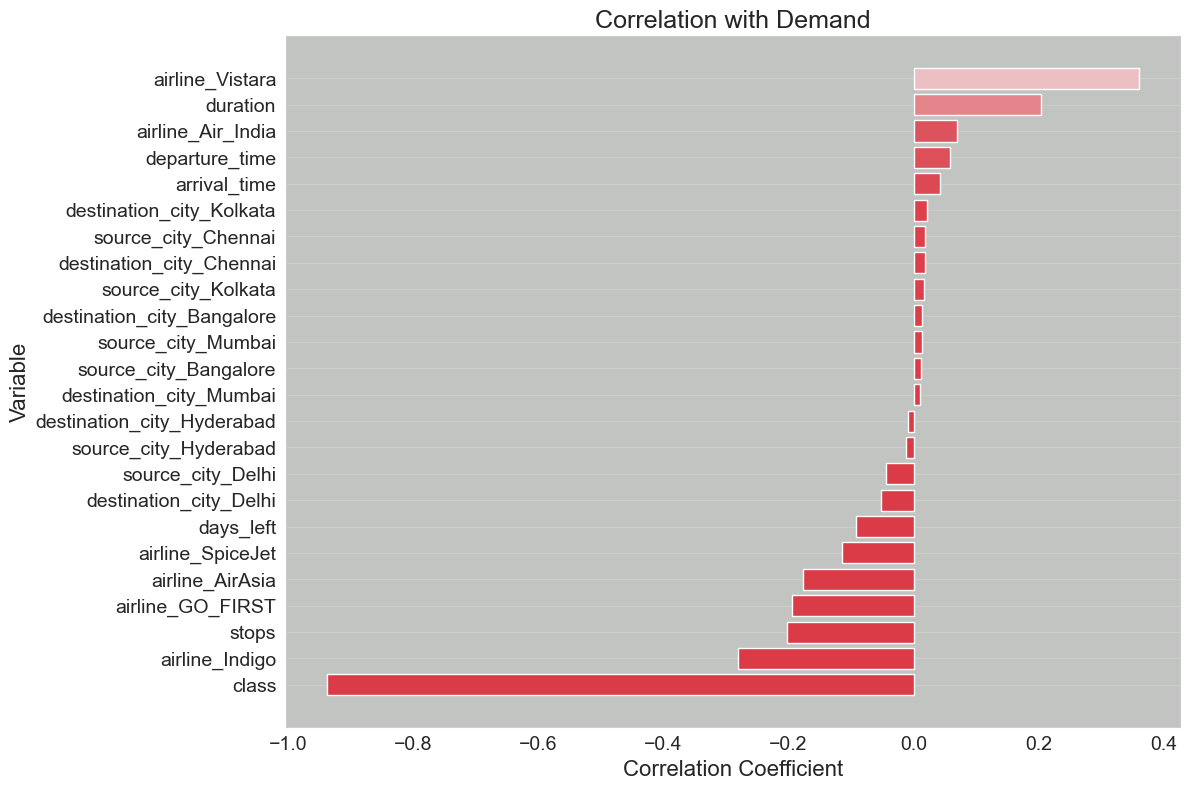

In [145]:
correlation_plot

In [146]:
#plotting residuals to show information on how well the model is predicting

def plot_residuals(model, dvalid, valid_y, save_path=None):
    preds = model.predict(dvalid)
    
    residuals = valid_y - preds
    
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})
    
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")
    
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)
        
    plt.close(fig)
    
    return fig

In [147]:
#plotting feature importance for xgb

def plot_feature_importance(model, booster):
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_type = "weight" if booster == "gblinear" else "gain"
    xgb.plot_importance(
        model, 
        importance_type=importance_type,
        ax=ax,
        title=f"Feature Importance based on {importance_type}",
    )
    plt.tight_layout()
    plt.close(fig)
    
    return fig

In [148]:
#create/get experiment function
def get_or_create_experiment(experiment_name):
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [149]:
experiment_id = get_or_create_experiment("Flight Price")

In [150]:
experiment_id

'792087743191039247'

In [151]:
mlflow.set_experiment(experiment_id=experiment_id)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [152]:
#creating optuna functions
optuna.logging.set_verbosity(optuna.logging.ERROR)

def champion_callback(study, frozen_trial):
    winner = study.user_attrs.get("winner", None)
    
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(f"Trial {frozen_trial.number} achieved value: {math.sqrt(frozen_trial.value)} with "
                  f"{improvement_percent:.4f}% improvement"
                  )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [153]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }
        
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(y_test, preds)
        
        #log to mlflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))
        
        return error

In [154]:
run_name = "parameter trials"

In [156]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    study = optuna.create_study(direction="minimize")
    
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])
    
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))
    
    mlflow.set_tags(
        tags={
            "project":"Flight Price Project", 
            "optimizer_engine":"optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )
    
    model = xgb.train(study.best_params, dtrain)
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")
    
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")
    
    residuals = plot_residuals(model, dvalid, y_test)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")
    
    artifact_path = "model"
    
    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )
    
    model_uri = mlflow.get_artifact_uri(artifact_path)

Initial trial 0 achieved value: 83229670.12886646
Trial 3 achieved value: 81431039.04916286 with 2.2088% improvement
Trial 5 achieved value: 14103278.98133793 with 477.3908% improvement
Trial 10 achieved value: 12396192.47855928 with 13.7711% improvement
Trial 84 achieved value: 11627070.683223706 with 6.6149% improvement
Trial 111 achieved value: 11525877.828990163 with 0.8780% improvement
Trial 113 achieved value: 11428479.596245585 with 0.8522% improvement
Trial 120 achieved value: 11088478.630057538 with 3.0663% improvement
Trial 151 achieved value: 11036410.236173708 with 0.4718% improvement


c:\Users\sabie\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\sabie\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [157]:
model_uri

'mlflow-artifacts:/792087743191039247/09b277055d1a464ab7ffaed5ef46da8e/artifacts/model'

In [158]:
loaded = mlflow.xgboost.load_model(model_uri)

In [159]:
loaded = mlflow.xgboost.load_model(model_uri)

In [160]:
batch_dmatrix = xgb.DMatrix(X)
inference = loaded.predict(batch_dmatrix)

infer_df = df.copy()
infer_df["predicted_demand"] = inference

In [161]:
infer_df

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,...,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,predicted_demand
0,0,SpiceJet,SG-8709,Delhi,2,2,5,Mumbai,1,2.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8167.352051
1,1,SpiceJet,SG-8157,Delhi,1,2,4,Mumbai,1,2.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7149.798340
2,2,AirAsia,I5-764,Delhi,1,2,1,Mumbai,1,2.17,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6293.682617
3,3,Vistara,UK-995,Delhi,4,2,0,Mumbai,1,2.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8106.169922
4,4,Vistara,UK-963,Delhi,4,2,4,Mumbai,1,2.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7882.457031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,4,0,2,Hyderabad,0,10.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,71880.648438
300149,300149,Vistara,UK-826,Chennai,0,0,5,Hyderabad,0,10.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68827.617188
300150,300150,Vistara,UK-832,Chennai,1,0,5,Hyderabad,0,13.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,60136.597656
300151,300151,Vistara,UK-828,Chennai,1,0,2,Hyderabad,0,10.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,75458.593750


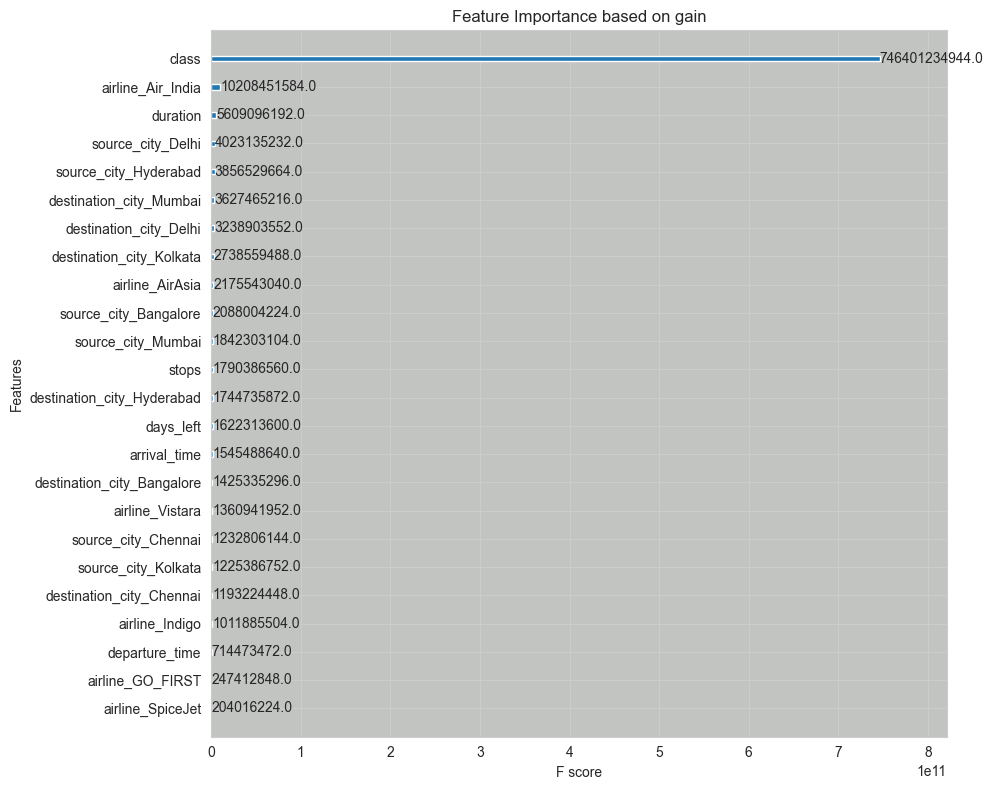

In [162]:
importances